In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp
from astropy.io import fits
from data_process import weight_nan_mean, load_calculation_data, calculate_jackknife_variance
from sklearn.neighbors import KDTree

In [2]:
Nside_jack = 4
r_p, dat = load_calculation_data('../calculation_data/result_r=3_100_15_quasar_lss_all_CMB_smoothed_6_tree.npy', return_rp=True)
dat_r = load_calculation_data('../calculation_data/result_r=3_100_15_random_quasar_lss_all_CMB_smoothed_6_tree.npy')
               
with open('label.bin', 'rb') as f:
    pix_q = np.load(f)
    pix_r = np.load(f)

In [3]:
value_r = dat_r[0]
weight_r = dat_r[1]

quasar_cata = np.load('../catalogue/quasar_lss_all.npy')
# c = coo.SkyCoord(ra=quasar_cata['ra']*u.degree, dec=quasar_cata['dec']*u.degree)
# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix_q = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

quasar_SDSS = fits.getdata('/uufs/chpc.utah.edu/common/home/astro/zheng/hd/data/SDSS16Q/DR16Q_v4.fits')
tree = KDTree(np.c_[quasar_SDSS['RA'], quasar_SDSS['DEC']], metric='euclidean')
que = tree.query(np.c_[quasar_cata['ra'], quasar_cata['dec']])
valid = que[0].flatten() < 5/3600
index = que[1].flatten()

M_I = quasar_SDSS['M_I'][index]
M_I[~valid] = np.nan
print('finish loading quasar catalogue')

random_sample = np.load('../catalogue/random_quasar_lss_all.npy')
# c = coo.SkyCoord(ra=random_sample['ra']*u.degree, dec=random_sample['dec']*u.degree)
# assert (random_sample['w']==1).all()
# l = c.galactic.l.to(u.rad).value
# b = c.galactic.b.to(u.rad).value
# pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)


print('finish loading random sample')

finish loading quasar catalogue
finish loading random sample


In [4]:
bins = np.linspace(0.8, 2.2, 30)            # the z cut applied to quasar lss all
result = np.digitize(quasar_cata['z'], bins)
kind = np.zeros(len(quasar_cata), int)
middles = []
high = []
low = []
for i in range(1, 30):
    index = np.where(result == i)[0]
    M = M_I[index]
    middle = np.percentile(M[~np.isnan(M)], 50)
    high.append(index[M <= middle])
    low.append(index[M >= middle])

index_h = np.concatenate(high)
index_l = np.concatenate(low)

In [5]:
for index, suffix in zip([index_h, index_l], ['high', 'low']):
    value = dat[0,index]
    weight = dat[1,index]
    pix = pix_q[index]
    sampler_sub  = calculate_jackknife_variance(value, weight, pix, value_r, weight_r, pix_r, norm_cov=True, return_jackknife=True)
    np.save(f'cross_corr_jackknife_kmeans_100_{suffix}', sampler_sub['jackknife'])
    # np.savetxt(f'./results/quasar_lss_all_{suffix}_cmb_smoothed_6', np.c_[r_p, sampler_sub['mean'], sampler_sub['std']])

## signal

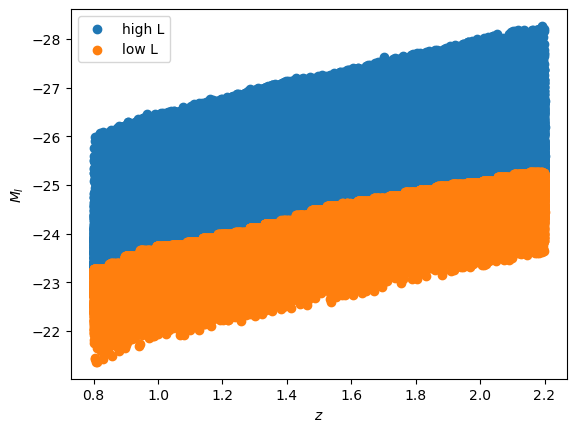

In [5]:
plt.scatter(quasar_cata['z'][index_h], M_I[index_h], label='high L')
plt.scatter(quasar_cata['z'][index_l], M_I[index_l], label='low L')
ax = plt.gca()
ax.set_xlabel('$z$')
ax.set_ylabel('$M_I$')
ax.invert_yaxis()
plt.legend()

In [17]:
Nside = 2048
image = np.zeros(hp.nside2npix(Nside))
image[hp.ang2pix(Nside, phi=np.deg2rad(quasar_cata['ra'][index_h]), theta=np.deg2rad(90 - quasar_cata['dec'][index_h]))] = 1
image[hp.ang2pix(Nside, phi=np.deg2rad(quasar_cata['ra'][index_l]), theta=np.deg2rad(90 - quasar_cata['dec'][index_l]))] = 2

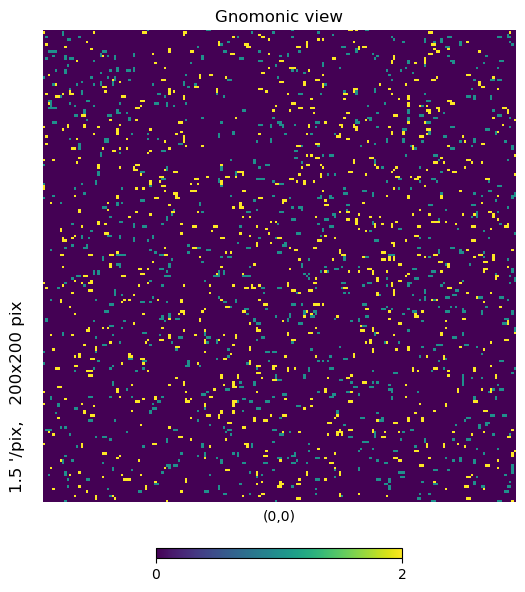

In [18]:
hp.visufunc.gnomview(image, rot=(0, 0, 0))

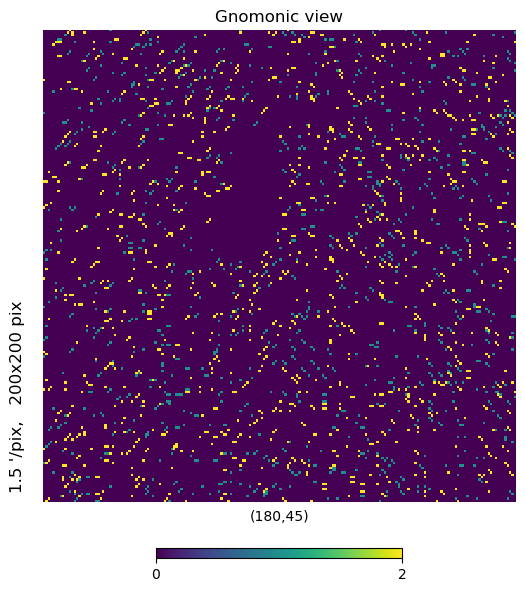

In [19]:
hp.visufunc.gnomview(image, rot=(180, 45, 0))

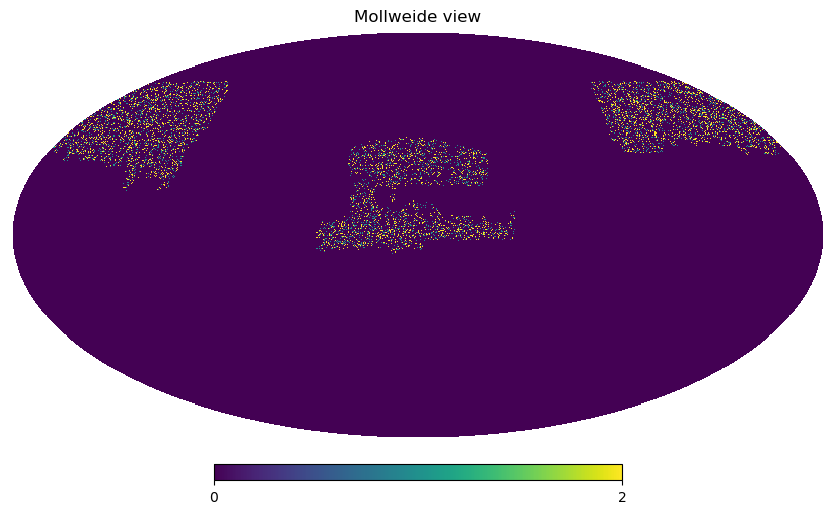

In [13]:
hp.mollview(image)

In [6]:
valid.sum()/len(valid)

0.999397744597158